In [3]:
import math
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import csv
import cv2
import random

from PIL import Image, ImageOps
from torch import Tensor, optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, trange
from nltk import sent_tokenize, word_tokenize
from gensim.models import Word2Vec


class SinusoidalPositionEmbeddings(torch.nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class TemporalEmbedding(torch.nn.Module):
    def __init__(self, dim_emb, dim_out):
        super().__init__()
        self.linear = torch.nn.Linear(dim_emb, dim_out)
        self.temb = SinusoidalPositionEmbeddings(dim_emb)

    def forward(self, x, time):
        temb = self.temb(time)
        emb = self.linear(temb)
        emb = emb[:, :, None, None]
        out = x + emb
        return out


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        base_channel = 16

        factor = 2 if bilinear else 1

        self.inc = (DoubleConv(n_channels, base_channel))
        self.down1 = (Down(base_channel, base_channel * 2))
        self.down2 = (Down(base_channel * 2, base_channel * 4 // factor))
        self.up1 = (Up(base_channel * 4, base_channel * 2 // factor, bilinear))
        self.up2 = (Up(base_channel * 2, base_channel, bilinear))
        self.outc = (OutConv(base_channel, n_classes))

        self.embed1 = TemporalEmbedding(1024, n_channels)
        self.embed2 = TemporalEmbedding(1024, base_channel)
        self.embed3 = TemporalEmbedding(1024, base_channel * 2)
        self.embed4 = TemporalEmbedding(1024, base_channel * 4)
        self.embed5 = TemporalEmbedding(1024, base_channel * 2)
        self.embed6 = TemporalEmbedding(1024, base_channel)

    def forward(self, x, t):
        x = self.embed1(x, t)
        x1 = self.inc(x)

        x1 = self.embed2(x1, t)
        x2 = self.down1(x1)

        x2 = self.embed3(x2, t)
        x3 = self.down2(x2)

        x3 = self.embed4(x3, t)
        x = self.up1(x3, x2)

        x = self.embed5(x, t)
        x = self.up2(x, x1)

        x = self.embed6(x, t)
        logits = self.outc(x)
        return logits


class UNetPlus(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNetPlus, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        base_channel = 32
        factor = 2 if bilinear else 1

        self.inc = DoubleConv(n_channels, base_channel)
        self.down1 = Down(base_channel, base_channel * 2)
        self.down2 = Down(base_channel * 2, base_channel * 4)
        self.down3 = Down(base_channel * 4, base_channel * 8)
        self.down4 = Down(base_channel * 8, base_channel * 16 // factor)

        self.up1 = Up(base_channel * 16, base_channel * 8 // factor, bilinear)
        self.up2 = Up(base_channel * 8, base_channel * 4 // factor, bilinear)
        self.up3 = Up(base_channel * 4, base_channel * 2 // factor, bilinear)
        self.up4 = Up(base_channel * 2, base_channel, bilinear)

        self.outc = OutConv(base_channel, n_classes)

        self.embed1 = TemporalEmbedding(1024, 1)
        self.embed2 = TemporalEmbedding(1024, base_channel)
        self.embed3 = TemporalEmbedding(1024, base_channel * 2)
        self.embed4 = TemporalEmbedding(1024, base_channel * 4)
        self.embed5 = TemporalEmbedding(1024, base_channel * 8)
        self.embed6 = TemporalEmbedding(1024, base_channel * 16)
        self.embed7 = TemporalEmbedding(1024, base_channel * 8)
        self.embed8 = TemporalEmbedding(1024, base_channel * 4)
        self.embed9 = TemporalEmbedding(1024, base_channel * 2)
        self.embed10 = TemporalEmbedding(1024, base_channel)

    def forward(self, x, t):
        x = self.embed1(x, t)
        x1 = self.inc(x)

        x1 = self.embed2(x1, t)
        x2 = self.down1(x1)

        x2 = self.embed3(x2, t)
        x3 = self.down2(x2)

        x3 = self.embed4(x3, t)
        x4 = self.down3(x3)

        x4 = self.embed5(x4, t)
        x5 = self.down4(x4)

        x5 = self.embed6(x5, t)
        x = self.up1(x5, x4)

        x = self.embed7(x, t)
        x = self.up2(x, x3)

        x = self.embed8(x, t)
        x = self.up3(x, x2)

        x = self.embed9(x, t)
        x = self.up4(x, x1)

        x = self.embed10(x, t)
        logits = self.outc(x)
        return logits


class DiffusionProcess:
    def __init__(self, device, batchSize=64, timeSteps=999, betaMode="Cosine"):
        self.batchSize = batchSize
        self.timeSteps = timeSteps
        self.betaMode = betaMode
        self.betas = None
        self.device = device
        self._initHyperparams()

    def _initHyperparams(self):
        if self.betaMode == "Quadratic":
            self.betas = self._getQuadraticBetas(self.device, self.timeSteps)
        elif self.betaMode == "Sigmoid":
            self.betas = self._getSigmoidBetas(self.device, self.timeSteps)
        elif self.betaMode == "Cosine":
            self.betas = self._getCosineBetas(self.device, self.timeSteps)
        self.alphas = 1.0 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_1_m_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def forward(self, x_0, t, noise, txt=None):
        img_pt_i = self.sqrt_alpha_bar[t].view((x_0.shape[0], 1, 1, 1)) * x_0
        noise_pt_i = self.sqrt_1_m_alpha_bar[t].view((x_0.shape[0], 1, 1, 1)) * noise
        x_i = img_pt_i + noise_pt_i
        return x_i

    def inverse(self, xt, et, t, txt=None):
        xt = xt.to(self.device)
        et = et.to(self.device)
        z = torch.randn_like(xt).to(self.device)
        noise_pt_tm1 = (self.betas[t] / self.sqrt_1_m_alpha_bar[t]) * et
        xt = (xt.to(self.device) - noise_pt_tm1.to(self.device)) / torch.sqrt(self.alphas[t]).to(self.device) + self.betas[t].sqrt() * z.to(self.device)
        return xt

    @staticmethod
    def _getQuadraticBetas(device, timeSteps):
        return torch.pow(torch.linspace(math.sqrt(0.0001), math.sqrt(0.02), timeSteps), 2).to(device)

    @staticmethod
    def _getSigmoidBetas(device, timeSteps):
        return torch.sigmoid(torch.linspace(-6, 6, timeSteps)).to(device) * (0.02 - 0.0001) + 0.0001

    @staticmethod
    # Reference: https://blog.csdn.net/Peach_____/article/details/128663957?spm=1001.2101.3001.6650.3&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-3-128663957-blog-128604816.235%5Ev38%5Epc_relevant_sort_base1&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-3-128663957-blog-128604816.235%5Ev38%5Epc_relevant_sort_base1&utm_relevant_index=4
    def _getCosineBetas(device, timeSteps, s=0.008):
        steps = timeSteps + 1
        x = torch.linspace(0, timeSteps, steps)
        alphas_cumprod = torch.cos(((x / timeSteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999).to(device)


class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indexes = list(dataset.keys())

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, index):
        index = self.indexes[index]
        txt, img = self.dataset[index]
        return txt, img


def _inputTxtData(csvFilePath):
    txtDataSet = {}
    allDocs = []
    with open(csvFilePath, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            index = int(row[0])
            text = word_tokenize(row[1])
            allDocs.append(text)
            txtDataSet[index] = text
    w2vModel = Word2Vec(allDocs, vector_size=64, window=3, min_count=1, workers=1)
    for key in txtDataSet.keys():
        doc = txtDataSet[key]
        newDoc = Tensor(np.array([w2vModel.wv[token] for token in doc]))
        txtDataSet[key] = newDoc
    return txtDataSet, w2vModel


def _inputImgData(directoryPath) -> dict:
    imgDataSet = {}
    transform = torchvision.transforms.ToTensor()
    for filename in os.listdir(directoryPath):
        if filename.endswith('.jpg'):
            image_path = os.path.join(directoryPath, filename)
            index = int(os.path.splitext(filename)[0])
            image = Image.open(image_path)
            imgDataSet[index] = transform(image)
    return imgDataSet


def dataLoading(batchSize, csvFilePath, directoryPath):
    dataset = {}
    txtDataSet, w2vModel = _inputTxtData(csvFilePath=csvFilePath)
    imgDataSet = _inputImgData(directoryPath=directoryPath)

    for key in txtDataSet.keys():
        txtData = txtDataSet.get(key)
        imgData = imgDataSet.get(key)
        dataset[key] = [txtData, imgData]

    dataLoader = DataLoader(CustomDataset(dataset), batch_size=batchSize, shuffle=True)
    return dataLoader, w2vModel


def modelTraining(model, process, optimizer, criterion, device, modelOutputPath, epochs, dataLoader=None):
    for e in trange(epochs):
        running_loss = 0
        for idx, (txt, image) in enumerate(dataLoader):
            if (txt.size()[0] != process.batchSize) or (image.size()[0] != process.batchSize):
                continue
            image = image.to(device)
            txt = txt.to(device)
            t = torch.randint(0, process.timeSteps, (process.batchSize,), device=device, dtype=torch.long)
            epsilon = torch.randn_like(image, device=device)
            diffused_image = process.forward(x_0=image, t=t, noise=epsilon, txt=txt)

            # Backprop
            optimizer.zero_grad()
            output = model(diffused_image.to(device), t.to(device))
            loss = criterion(epsilon.to(device), output)
            loss.backward()
            optimizer.step()
            loss_value = loss.cpu().item()
            running_loss += loss_value

        # Save model after every epoch
        torch.save(model.state_dict(), modelOutputPath)
        running_loss /= len(dataLoader)
        print(f"Mean loss for Epoch {e + 1}: {running_loss:.4f}\n")


def modelLoading(modelType, modelSize, modelInputPath, device):
    model = modelType(*modelSize).to(device)
    model.load_state_dict(torch.load(modelInputPath))
    model.eval()

    #model = model.to("cpu")
    #torch.save(model.state_dict(), "autodl-fs/*/AnimeCPU (300).pth")

    return model


def modelInferring(model, process, device, txt, testLoader=None, x_t=None):
    print(">> Inferring\n")
    model.eval()
    with torch.no_grad():
        for t in trange(process.timeSteps - 1, -1, -1):  # todo
            time = torch.ones(process.batchSize) * t
            epsilonPredict = model(x_t, time.to(device))  # predict noise
            x_t = process.inverse(xt=x_t, et=epsilonPredict, t=t, txt=epsilonPredict)

            
    labels = ["Generated Images"] * 9
    x_t = Tensor.cpu(x_t)

    for i in range(9):
        res = torch.clamp(x_t[i], 0, 1).permute(1, 2, 0)
        plt.subplot(3, 3, i + 1)
        plt.tight_layout()
        plt.imshow(res, interpolation="none")
        plt.title(labels[i])
        
        ID = random.randint(1, 9999999)
        res = res.numpy().astype(np.float32) * 255
        res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f"ANIME_{ID}.png", res)
    plt.show()


""" Dashboard """
# Training Options:
batch_size = 64  # 64
epochs = 300  # 50
betaMode = ["Quadratic", "Sigmoid", "Cosine"][0]

# Process Options:
reloadModel = False
trainModel = True
testModel = True

# Data Options:
txt_csvFilePath = "data/AnimeFaces/tags.csv"
img_directoryPath = "data/AnimeFaces/images"

# Reloading Options:
modelInputPath = "./AnimeCPU (300).pth"
modelOutputPath = "_.pth"
modelSize = (3, 3)  # (#channel, #classes)
modelType = UNetPlus

# Test Options:
docs = ["blue hair red eyes"] * batch_size
x_t = torch.randn(batch_size, 3, 64, 64)


""" Initializing/Reloading """
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = modelLoading(modelType=modelType, modelSize=modelSize, modelInputPath=modelInputPath, device=device) if reloadModel else UNetPlus(*modelSize).to(device)
process = DiffusionProcess(device=device, batchSize=batch_size, betaMode=betaMode)


""" Input """
dataLoader, w2vModel = dataLoading(batchSize=process.batchSize,
                                   csvFilePath=txt_csvFilePath,
                                   directoryPath=img_directoryPath)


""" Training """
if trainModel:
    # Initialize training settings of the Adam optimizer and the MSELoss criterion;
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    criterion = torch.nn.MSELoss()
    modelTraining(model=model,
                  process=process,
                  optimizer=optimizer,
                  criterion=criterion,
                  device=device,
                  modelOutputPath=modelOutputPath,
                  epochs=epochs,
                  dataLoader=dataLoader)


>> Inferring


100%|██████████| 999/999 [13:44<00:00,  1.21it/s]


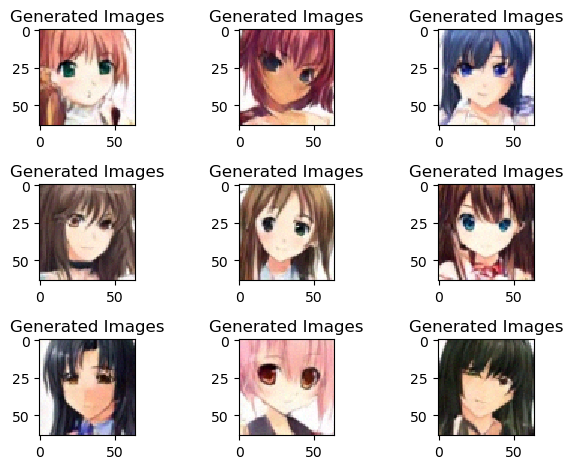

In [4]:
""" Sampling """
if testModel:
    # Test Sample:
    x_t = x_t.to(device)
    dataset = {}
    idx = 0
    for doc in docs:
        txtData = Tensor(np.array([w2vModel.wv[token] for token in word_tokenize(doc)]))
        imgData = 0
        dataset[idx] = [txtData, imgData]
        idx += 1
    testDataLoader = DataLoader(CustomDataset(dataset), batch_size=batch_size, shuffle=False)
    for batchIdx, (txtBatch, _) in enumerate(testDataLoader):
        modelInferring(model=model,
                       process=process,
                       device=device,
                       x_t=x_t,
                       txt=txtBatch)